# Final project: Meta Aggregation #

### by: Ortal & Raz & Michal
### guidence: Hila

In [ ]:
pip install scikit-multilearn

In [ ]:
pip install shap

In [ ]:
pip install interpret

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import train_test_split
from GetProcessedData import get_question_dfs
from AggregationMethods.ConfidenceMethods import highest_average_confidence
from AggregationMethods.SurprisinglyPopular import surprisingly_pop_answer
from AggregationMethods.MajorityRule import majority_answer
from FeaturesExtraction.AnswerFeatures import AnswerF
from FeaturesExtraction.AnswerFeaturesSubgroups import AnswerSubF
from FeaturesExtraction.ConfidenceFeatures import ConfidenceF
from FeaturesExtraction.ConfidenceFeaturesSubgroups import ConfidenceSubF
from FeaturesExtraction.PredictionFeatures import PredictionsF
import Pipeline.MultiLabelPipeline as MLpip

In [2]:
#libraries
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# from ProjectFramework.GetProcessedData import get_question_dfs
# from ProjectFramework.Pipeline.MultiLabelPipeline import create_data_df

#import ProjectFramework.Pipeline.MultiLabelPipeline.MultiLabelPipeline.create_data_df
import numpy as np 
import pandas as pd 
import os
import json 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
import shap

In [3]:
RF = RandomForestClassifier(random_state=0)  #has no predict_proba option
LR = LogisticRegression(solver = 'liblinear')
GNB = GaussianNB()
SVC = LinearSVC(random_state=0)
DT = DecisionTreeClassifier(random_state=0) 
BNB = BernoulliNB()
SGD = SGDClassifier()  #has no predict_proba option

In [5]:
# get compleate data frame with features:

DATA = MLpip.get_data()
LABELS = MLpip.get_label_names()

y = DATA[LABELS]
x = DATA.drop(LABELS,axis='columns', inplace=False, errors='ignore')
x.drop('dataset_id',axis='columns', inplace=True, errors='ignore')

In [6]:
Accuracy = {}

In [7]:
DATA.shape

(842, 48)

In [8]:
LABELS

dict_values(['HAC', 'MR', 'NONE', 'SP', 'WC'])

## classifier_chain

In [8]:
# split data into train and test using leave one out validation
results_c_rf = {}
results_c_lr = {}
results_c_gnb = {}
results_c_dt = {}
results_c_bnb = {}
results_c_sgd = {}

# res = []
loo = LeaveOneOut()
loo.get_n_splits(x)

for train_index, test_index in loo.split(x):
    # print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    # print(X_train, X_test, y_train, y_test)
    ## HERE - run moddels
    
#     clf_chain_RF = MLpip.classifier_chain(x_train, y_train, RandomForestClassifier(random_state=0))
#     results_c_rf.update(MLpip.get_chain_model_results(clf_chain_RF, x_test))

    clf_chain_LR = MLpip.classifier_chain(x_train, y_train,LogisticRegression(solver = 'liblinear',max_iter=10000))
    results_c_lr.update(MLpip.get_chain_model_results(clf_chain_LR, x_test))

    clf_chain_GNB = MLpip.classifier_chain(x_train, y_train, GaussianNB())
    results_c_gnb.update(MLpip.get_chain_model_results(clf_chain_GNB, x_test))

    clf_chain_DT = MLpip.classifier_chain(x_train, y_train, DecisionTreeClassifier(random_state=0))
    results_c_dt.update(MLpip.get_chain_model_results(clf_chain_DT, x_test))

    clf_chain_BNB = MLpip.classifier_chain(x_train, y_train, BernoulliNB())
    results_c_bnb.update(MLpip.get_chain_model_results(clf_chain_BNB, x_test))

#     clf_chain_SGD = MLpip.classifier_chain(x_train, y_train, SGDClassifier())
#     results_c_sgd.update(MLpip.get_chain_model_results(clf_chain_SGD, x_test))


# Accuracy['c_RF'] = MLpip.get_accuracy(results_c_rf, y) #no proba
Accuracy['c_LR'] = MLpip.get_accuracy(results_c_lr, y)
Accuracy['c_GNB'] = MLpip.get_accuracy(results_c_gnb, y)   
Accuracy['c_DT'] = MLpip.get_accuracy(results_c_dt, y)    
Accuracy['c_BNB'] = MLpip.get_accuracy(results_c_bnb, y) 
# Accuracy['c_SGD'] = MLpip.get_accuracy(results_c_sgd, y) #no proba


In [9]:
Accuracy

{'c_LR': 0.669833729216152,
 'c_GNB': 0.5724465558194775,
 'c_DT': 0.6757719714964371,
 'c_BNB': 0.5629453681710214}

## binary_relevance

In [10]:
# split data into train and test using leave one out validation
results_b_rf = {}
results_b_lr = {}
results_b_gnb = {}
results_b_dt = {}
results_b_bnb = {}
results_b_sgd = {}

# res = []
loo = LeaveOneOut()
loo.get_n_splits(x)

for train_index, test_index in loo.split(x):
    # print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    # print(X_train, X_test, y_train, y_test)
    ## HERE - run moddels
    
#     clf_chain_RF = MLpip.binary_relevance(x_train, y_train, RandomForestClassifier(random_state=0))
#     results_b_rf.update(MLpip.get_binary_model_results(clf_chain_RF, x_test))

    clf_chain_LR = MLpip.binary_relevance(x_train, y_train,LogisticRegression(solver = 'liblinear',max_iter=10000))
    results_b_lr.update(MLpip.get_binary_model_results(clf_chain_LR, x_test))

    clf_chain_GNB = MLpip.binary_relevance(x_train, y_train, GaussianNB())
    results_b_gnb.update(MLpip.get_binary_model_results(clf_chain_GNB, x_test))

    clf_chain_DT = MLpip.binary_relevance(x_train, y_train, DecisionTreeClassifier(random_state=0))
    results_b_dt.update(MLpip.get_binary_model_results(clf_chain_DT, x_test))

    clf_chain_BNB = MLpip.binary_relevance(x_train, y_train, BernoulliNB())
    results_b_bnb.update(MLpip.get_binary_model_results(clf_chain_BNB, x_test))

#     clf_chain_SGD = MLpip.binary_relevance(x_train, y_train, SGDClassifier())
#     results_b_sgd.update(MLpip.get_binary_model_results(clf_chain_SGD, x_test))

# Accuracy['b_RF'] = MLpip.get_accuracy(results_b_rf, y)
Accuracy['b_LR'] = MLpip.get_accuracy(results_b_lr, y)
Accuracy['b_GNB'] = MLpip.get_accuracy(results_b_gnb, y)   
Accuracy['b_DT'] = MLpip.get_accuracy(results_b_dt, y)    
Accuracy['b_BNB'] = MLpip.get_accuracy(results_b_bnb, y) 
# Accuracy['b_SGD'] = MLpip.get_accuracy(results_b_sgd, y)


error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results
error in get_binary_model_results


In [11]:
Accuracy

{'c_LR': 0.669833729216152,
 'c_GNB': 0.5724465558194775,
 'c_DT': 0.6757719714964371,
 'c_BNB': 0.5629453681710214,
 'b_LR': 0.7102137767220903,
 'b_GNB': 0.6520190023752969,
 'b_DT': 0.40498812351543945,
 'b_BNB': 0.5878859857482185}

## label_powerset

In [12]:
# split data into train and test using leave one out validation
results_p_rf = {}
results_p_lr = {}
results_p_gnb = {}
results_p_dt = {}
results_p_bnb = {}
results_p_sgd = {}

# res = []
loo = LeaveOneOut()
loo.get_n_splits(x)

for train_index, test_index in loo.split(x):
    # print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    # print(X_train, X_test, y_train, y_test)
    ## HERE - run moddels
    
#     clf_chain_RF = MLpip.label_powerset(x_train, y_train, RandomForestClassifier(random_state=0))
#     results_p_rf.update(MLpip.get_binary_model_results(clf_chain_RF, x_test))

    clf_chain_LR = MLpip.label_powerset(x_train, y_train,LogisticRegression(solver = 'liblinear',max_iter=10000))
    results_p_lr.update(MLpip.get_binary_model_results(clf_chain_LR, x_test))

    clf_chain_GNB = MLpip.label_powerset(x_train, y_train, GaussianNB())
    results_p_gnb.update(MLpip.get_binary_model_results(clf_chain_GNB, x_test))

#     clf_chain_DT = MLpip.label_powerset(x_train, y_train, DecisionTreeClassifier(random_state=0))
#     results_p_dt.update(MLpip.get_binary_model_results(clf_chain_DT, x_test))

    clf_chain_BNB = MLpip.label_powerset(x_train, y_train, BernoulliNB())
    results_p_bnb.update(MLpip.get_binary_model_results(clf_chain_BNB, x_test))

#     clf_chain_SGD = MLpip.label_powerset(x_train, y_train, SGDClassifier())
#     results_p_sgd.update(MLpip.get_binary_model_results(clf_chain_SGD, x_test))

# Accuracy['p_RF'] = MLpip.get_accuracy(results_p_rf, y)
Accuracy['p_LR'] = MLpip.get_accuracy(results_p_lr, y)
Accuracy['p_GNB'] = MLpip.get_accuracy(results_p_gnb, y)   
# Accuracy['p_DT'] = MLpip.get_accuracy(results_p_dt, y)    
Accuracy['p_BNB'] = MLpip.get_accuracy(results_p_bnb, y) 
# Accuracy['p_SGD'] = MLpip.get_accuracy(results_p_sgd, y)


In [13]:
Accuracy

{'c_LR': 0.669833729216152,
 'c_GNB': 0.5724465558194775,
 'c_DT': 0.6757719714964371,
 'c_BNB': 0.5629453681710214,
 'b_LR': 0.7102137767220903,
 'b_GNB': 0.6520190023752969,
 'b_DT': 0.40498812351543945,
 'b_BNB': 0.5878859857482185,
 'p_LR': 0.7304038004750594,
 'p_GNB': 0.5914489311163895,
 'p_BNB': 0.6888361045130641}

In [26]:
### get reasults from extra data as test (the 400 matching all the methods):::

exData = pd.read_csv('resultsExtras.csv', index_col=0)
test_mx = exData.drop(LABELS,axis='columns', inplace=False, errors='ignore')
test_mx.drop('dataset_id',axis='columns', inplace=True, errors='ignore')

test_my = exData[LABELS]

In [28]:
test_my_E = pd.concat([y,test_my],ignore_index=True)

test_my_E.shape

(1281, 5)

In [35]:
results_E_lr = {}
results_E_gnb = {}
results_E_bnb = {}

# results_E_lr = results_p_lr
# results_E_gnb = results_p_gnb
# results_E_bnb = results_p_bnb

# results_p_rf = {}
# results_p_lr = {}
# results_p_gnb = {}
# results_p_dt = {}
# results_p_bnb = {}
# results_p_sgd = {}

# clf_chain_LR = MLpip.label_powerset(x_train, y_train,LogisticRegression(solver = 'liblinear',max_iter=10000))
results_E_lr.update(MLpip.get_binary_model_results(clf_chain_LR, test_mx))

# clf_chain_GNB = MLpip.label_powerset(x_train, y_train, GaussianNB())
results_E_gnb.update(MLpip.get_binary_model_results(clf_chain_GNB, test_mx))

# clf_chain_BNB = MLpip.label_powerset(x_train, y_train, BernoulliNB())
results_E_bnb.update(MLpip.get_binary_model_results(clf_chain_BNB, test_mx))


Accuracy['ext_p_LR'] = MLpip.get_accuracy(results_E_lr, test_my)
Accuracy['ext_p_GNB'] = MLpip.get_accuracy(results_E_gnb, test_my)   
Accuracy['ext_p_BNB'] = MLpip.get_accuracy(results_E_bnb, test_my) 

In [36]:
Accuracy

{'c_LR': 0.669833729216152,
 'c_GNB': 0.5724465558194775,
 'c_DT': 0.6757719714964371,
 'c_BNB': 0.5629453681710214,
 'b_LR': 0.7102137767220903,
 'b_GNB': 0.6520190023752969,
 'b_DT': 0.40498812351543945,
 'b_BNB': 0.5878859857482185,
 'p_LR': 0.7304038004750594,
 'p_GNB': 0.5914489311163895,
 'p_BNB': 0.6888361045130641,
 'ext_p_LR': 0.28929384965831434,
 'ext_p_GNB': 0.7539863325740319,
 'ext_p_BNB': 0.3211845102505695}

In [ ]:
# from sklearn.metrics import hamming_loss, accuracy_score 

# print("accuracy_score:", accuracy_score(y, res))
# print("Hamming_loss:", hamming_loss(y, res))

## K-fold implementation

In [ ]:
# split data into train and test using k-fold cross validation

results_k_b_rf = {}
results_k_b_lr = {}
results_k_b_gnb = {}
results_k_b_dt = {}
results_k_b_bnb = {}
results_k_b_sgd = {}

kf = KFold(n_splits=3, random_state=None, shuffle=False) # Define the split - into 10 folds 
kf.get_n_splits(x) # returns the number of splitting iterations in the cross-validator

for train_index, test_index in kf.split(x):
    # print(“TRAIN:”, train_index, “TEST:”, test_index)
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    ## HERE - run moddels
    clf_chain_RF = MLpip.binary_relevance(x_train, y_train, RandomForestClassifier())
    results_k_b_rf.update(MLpip.get_binary_model_results(clf_chain_RF, x_test))

    clf_chain_LR = MLpip.binary_relevance(x_train, y_train,LogisticRegression(solver = 'liblinear',max_iter=10000))
    results_k_b_lr.update(MLpip.get_binary_model_results(clf_chain_LR, x_test))

    clf_chain_GNB = MLpip.binary_relevance(x_train, y_train, GaussianNB())
    results_k_b_gnb.update(MLpip.get_binary_model_results(clf_chain_GNB, x_test))

#     clf_chain_DT = MLpip.binary_relevance(x_train, y_train, DecisionTreeClassifier(random_state=0))
#     results_k_b_dt.update(MLpip.get_binary_model_results(clf_chain_DT, x_test))

    clf_chain_BNB = MLpip.binary_relevance(x_train, y_train, BernoulliNB())
    results_k_b_bnb.update(MLpip.get_binary_model_results(clf_chain_BNB, x_test))

#     clf_chain_SGD = MLpip.binary_relevance(x_train, y_train, SGDClassifier())
#     results_k_b_sgd.update(MLpip.get_binary_model_results(clf_chain_SGD, x_test))

Accuracy['k_b_RF'] = MLpip.get_accuracy(results_k_b_rf, y)
Accuracy['k_b_LR'] = MLpip.get_accuracy(results_k_b_lr, y)
Accuracy['k_b_GNB'] = MLpip.get_accuracy(results_k_b_gnb, y)   
# Accuracy['k_b_DT'] = MLpip.get_accuracy(results_k_b_dt, y)    
Accuracy['k_b_BNB'] = MLpip.get_accuracy(results_k_b_bnb, y) 
# Accuracy['k_b_SGD'] = MLpip.get_accuracy(results_k_b_sgd, y)


In [ ]:
Accuracy

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform k-fold cross validation
k = 10
scores = cross_val_score(model, x, y, cv=k)
print “Cross-validated scores:”, scores
    
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=k)
plt.scatter(y, predictions)

## present accuracy

In [ ]:
Accuracy

## train one data source and test on other

In [ ]:
Accuracy = {}

In [ ]:
droper = ['dataset_id']
droper.extend(LABELS)

main_train = DATA.loc[DATA['dataset_id'] != 2]
main_test = DATA.loc[DATA['dataset_id'] == 2]


x_train,y_train = main_train.drop(droper,axis='columns', inplace=False, errors='ignore'), main_train[LABELS]
x_test, y_test = main_test.drop(droper,axis='columns', inplace=False, errors='ignore'), main_test[LABELS]


In [ ]:
p_results_k_b_rf = {}
p_results_k_b_lr = {}
p_results_k_b_gnb = {}
p_results_k_b_dt = {}
p_results_k_b_bnb = {}
p_results_k_b_sgd = {}


## HERE - run moddels
clf_chain_RF = MLpip.binary_relevance(x_train, y_train, RandomForestClassifier())
p_results_k_b_rf.update(MLpip.get_binary_model_results(clf_chain_RF, x_test))

clf_chain_LR = MLpip.binary_relevance(x_train, y_train,LogisticRegression(solver = 'liblinear',max_iter=10000))
p_results_k_b_lr.update(MLpip.get_binary_model_results(clf_chain_LR, x_test))

clf_chain_GNB = MLpip.binary_relevance(x_train, y_train, GaussianNB())
p_results_k_b_gnb.update(MLpip.get_binary_model_results(clf_chain_GNB, x_test))

clf_chain_DT = MLpip.binary_relevance(x_train, y_train, DecisionTreeClassifier(random_state=0))
p_results_k_b_dt.update(MLpip.get_binary_model_results(clf_chain_DT, x_test))

clf_chain_BNB = MLpip.binary_relevance(x_train, y_train, BernoulliNB())
p_results_k_b_bnb.update(MLpip.get_binary_model_results(clf_chain_BNB, x_test))

# clf_chain_SGD = MLpip.binary_relevance(x_train, y_train, SGDClassifier())
# p_results_k_b_sgd.update(MLpip.get_binary_model_results(clf_chain_SGD, x_test))

Accuracy['partial_2_k_b_RF'] = MLpip.get_accuracy(p_results_k_b_rf, y)
Accuracy['partial_2_k_b_LR'] = MLpip.get_accuracy(p_results_k_b_lr, y)
Accuracy['partial_2_k_b_GNB'] = MLpip.get_accuracy(p_results_k_b_gnb, y)   
Accuracy['partial_2_k_b_DT'] = MLpip.get_accuracy(p_results_k_b_dt, y)    
Accuracy['partial_2_k_b_BNB'] = MLpip.get_accuracy(p_results_k_b_bnb, y) 
# Accuracy['partial_1_k_b_SGD'] = MLpip.get_accuracy(p_results_k_b_sgd, y)

In [ ]:
Accuracy

## shap feature evaluation

In [ ]:
# #Random Forest Model
# rfc=RandomForestClassifier()
# model_2=rfc.fit(x_train,y_train['MR'])
# rfc_predict=model_2.predict(x_test)

# # load JS vis
# shap.initjs() 

# # create a tree explainer for Random Forest
# explainer = shap.TreeExplainer(model_2)

# #sample 100 observations from the test data
# observations = x_test.sample(100, random_state=42)

# #create an explainer
# shap_values = explainer.shap_values(observations)

# #generate a summary plot
# shap.summary_plot(shap_values[1], features=observations)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Permutation explainer: 170it [00:13,  4.21it/s]                                                                        


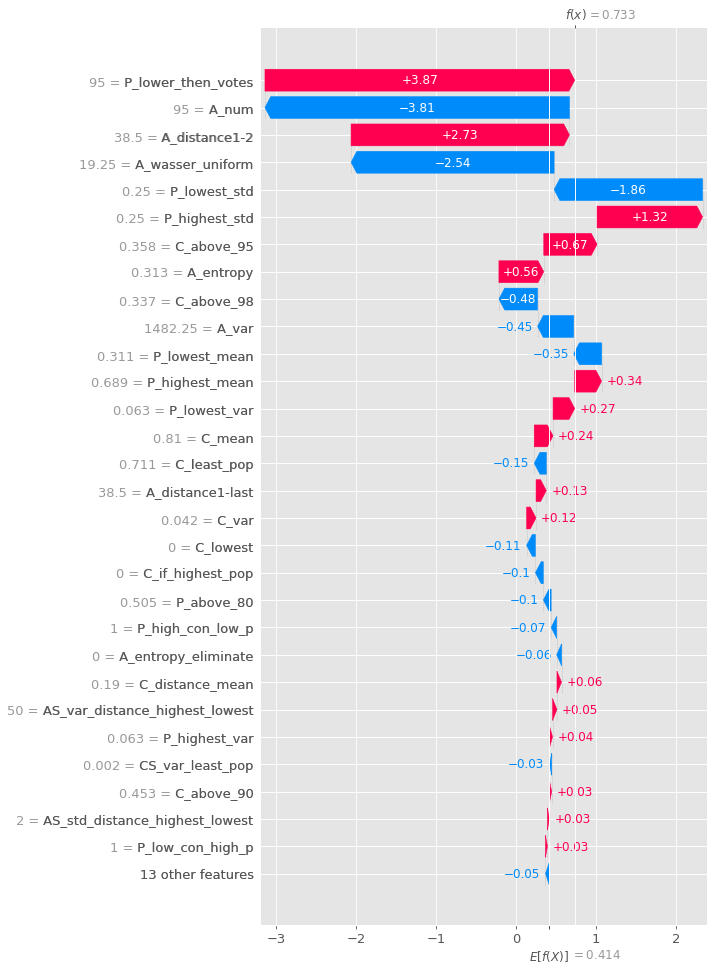

In [12]:
import sklearn

# a classic housing price dataset
X100 = shap.utils.sample(x_test, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
#model = GaussianNB()
model.fit(x_test, y_test['MR'])

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(x_test)

shap.plots.waterfall(shap_values[18], max_display=30)

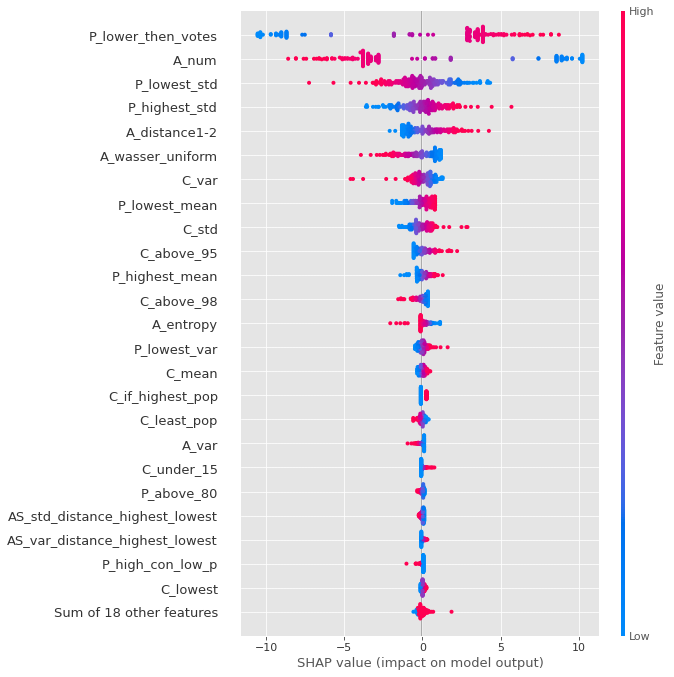

In [13]:
shap.plots.beeswarm(shap_values, max_display=25)

In [ ]:
model.fit(x_test, y_test['HAC'])

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(x_test)

shap.plots.waterfall(shap_values[18], max_display=30)

In [ ]:
shap.plots.beeswarm(shap_values, max_display=25)

In [ ]:
model.fit(x_test, y_test['SP'])

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(x_test)

shap.plots.waterfall(shap_values[18], max_display=30)

In [ ]:
shap.plots.beeswarm(shap_values, max_display=25)

In [ ]:
model.fit(x_test, y_test['WC'])

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(x_test)

shap.plots.waterfall(shap_values[18], max_display=30)

In [ ]:
shap.plots.beeswarm(shap_values, max_display=30)

In [ ]:
model.fit(x_test, y_test['NONE'])

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(x_test)

shap.plots.waterfall(shap_values[18], max_display=30)

In [ ]:
shap.plots.beeswarm(shap_values, max_display=30)

In [ ]:
# # fit a GAM model to the data
# import interpret
# import interpret.glassbox
# model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
# model_ebm.fit(x_test, y_test['MR'])

# # explain the GAM model with SHAP
# explainer_ebm = shap.Explainer(model_ebm.predict, X100)
# shap_values_ebm = explainer_ebm(x_test)

# shap.plots.beeswarm(shap_values_ebm, max_display=40)

In [ ]:
# shap.plots.bar(shap_values, max_display=30)

In [ ]:
# https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

# shap.dependence_plot("A_num", shap_values_ebm, x_test)

In [ ]:
# y_train['HAC']
# y_train['MR']
# y_train['SP']
# y_train['WC']


## confusion matrix

In [ ]:
#confusion matrix visualization

def plot_confusion_matrix(test_Y, predict_y):
    C = confusion_matrix(test_Y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [1,2]
    cmap=sns.light_palette("#45c6c4")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

plot_confusion_matrix(y_test['MR'], model.predict(x_test))